<a href="https://colab.research.google.com/github/dancanangwenyi/4121-Module-A-Notes/blob/master/ExplainableDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Create a Denosing Autoencoder and train all the data on it.
# After training generate all the data and save it to a file in google drive / see if there is a way to save the states
# of the file as different in each iteration

# Use the data with small dimesnionality to train a classifier
# Then based on a given prediction find which genes are actually unique
# Try both classifier , for now I will test the random forest explainer.

In [2]:
#Dependencies installation
!pip install torch
!pip install torchvision
!pip install shap
!pip install somoclu==1.6
!pip install

ERROR: You must give at least one requirement to install (see "pip help install")


In [3]:
import math
import os
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
# Mount the drive to access the data
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
#Change directory and Preview all the available data
%cd gdrive/MyDrive/Masters/data
%ls

/content/gdrive/MyDrive/Masters/data
TCGA222_countData_GE_RPKM_normalised_logT.csv  TCGA222_countData_GE.tsv
TCGA222_countData_GE_RPKM_normalised_logT.tsv  TCGA222_metadata.tsv


In [42]:
# Data operations
class TCGADataset(Dataset):
    def __init__(self):
        # data loading
        df_transposed = pd.read_csv('TCGA222_countData_GE_RPKM_normalised_logT.tsv', index_col=0, sep='\t')
        features = df_transposed.index.values  # Extract column names as labels
        self.features = features
        metadata = pd.read_csv('TCGA222_metadata.tsv',  sep='\t')
        short_letter_codes = metadata['shortLetterCode'].values
        labels = np.array(short_letter_codes)
        self.labels = labels
        for column in df_transposed.columns:
            df_transposed[column] = (df_transposed[column] - df_transposed[column].min()) / (df_transposed[column].max() - df_transposed[column].min())
        df = df_transposed.transpose()
        self.df = df
        tcga_data = np.array(df)
        print(tcga_data)
        print(labels)
        self.x = torch.from_numpy(tcga_data)
        self.n_samples = tcga_data.shape[0]
        self.sample_size = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.n_samples

In [43]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_neurons, hidden_one_neurons, hidden_two_neurons):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder_hidden_one = nn.Linear(input_neurons, hidden_one_neurons)
        self.encoder_hidden_two = nn.Linear(hidden_one_neurons, hidden_two_neurons)
        self.decoder_hidden_one = nn.Linear(hidden_two_neurons, hidden_one_neurons)
        self.decoder_hidden_two = nn.Linear(hidden_one_neurons, input_neurons)

    def forward(self, x):
        hidden_one = torch.relu(self.encoder_hidden_one(x))
        hidden_two = torch.relu(self.encoder_hidden_two(hidden_one))
        hidden_one_reconstructed = torch.relu(self.decoder_hidden_one(hidden_two))
        reconstructed_output = torch.relu(self.decoder_hidden_two(hidden_one_reconstructed))
        return hidden_two, reconstructed_output

    def get_weights_hidden_one(self):
        return self.encoder_hidden_one.weight.data

    def get_weights_hidden_two_to_encoded(self):
        return self.encoder_hidden_two.weight.data

In [44]:
def train_denoising_autoencoder(dataset, hidden_one, hidden_two, epochs, batch_size, noise_factor):
    is_train = True
    num_epochs = epochs
    batch_size = batch_size
    num_samples = len(dataset)
    num_input_neurons = dataset.__getitem__(0)
    num_input_neurons = len(num_input_neurons)
    hidden_one_neurons = hidden_one
    hidden_two_neurons = hidden_two
    num_iterations = math.ceil(num_samples / batch_size)
    # prepare data loaders
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    print(f"Input layer size:  {num_input_neurons} neurons")
    print(f"Hidden layer one size:  {hidden_one_neurons} neurons")
    print(f"Hidden layer one size:  {hidden_two_neurons} neurons")
    # Neural Network
    model = DenoisingAutoencoder(num_input_neurons, hidden_one_neurons, hidden_two_neurons).to(device)
    print(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    if is_train:
        for epoch in range(num_epochs):
            train_loss = 0.0
            for i, (data) in enumerate(dataloader):
                data = Variable(data).float()
                data_noisy = data + noise_factor * torch.randn(data.size())
                data = data.to(device)
                data_noisy = data_noisy.to(device)
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing *noisy* images to the model
                representation, reconstructed_output = model(data_noisy)
                loss = criterion(reconstructed_output, data)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
            train_loss = train_loss / len(dataloader)
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        return model
        # np.savetxt(fname="yano_dataset_rep.csv", X=representation_list_np, fmt='%f', delimiter=',')
        # print(representation_list)

In [50]:
def generate_representations(model, dataset, batch_size):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    representation_list = []
    criterion = nn.MSELoss()
    with torch.no_grad():
        count = 1
        for data in dataloader:
            data = data.float().to(device)  # Ensure data type matches the model's weight tensor
            representation, reconstructed_output = model(data)
            loss = criterion(reconstructed_output, data)
            representation_list.append(representation.cpu().numpy())
            print('Sample: {} \tThe Loss: {:.6f}'.format(count, loss.item() * data.size(0)))
    representation_array = np.concatenate(representation_list, axis=0)
    return pd.DataFrame(representation_array)

In [51]:
tcga_dataset = TCGADataset()

[[0.9878157  1.         0.97745979 ... 0.03688518 0.         0.04842055]
 [1.         0.9820261  0.97966348 ... 0.03868548 0.         0.05078388]
 [0.99995849 1.         0.96543216 ... 0.21994039 0.         0.04973306]
 ...
 [1.         0.8817558  0.97142904 ... 0.21993432 0.02771526 0.07300776]
 [1.         0.94343477 0.99657708 ... 0.03579923 0.         0.04699499]
 [0.98071568 1.         0.97505978 ... 0.03806559 0.         0.04997013]]
['TP' 'NT' 'NT' 'TP' 'NT' 'NT' 'TP' 'NT' 'TP' 'TP' 'TP' 'NT' 'NT' 'TP'
 'TP' 'NT' 'NT' 'TP' 'NT' 'TP' 'TP' 'TP' 'TP' 'NT' 'TP' 'NT' 'NT' 'TP'
 'NT' 'TP' 'NT' 'NT' 'TP' 'TP' 'TP' 'NT' 'TP' 'TP' 'NT' 'NT' 'TP' 'NT'
 'NT' 'NT' 'TP' 'NT' 'TP' 'NT' 'NT' 'NT' 'TP' 'NT' 'NT' 'TP' 'TP' 'TP'
 'NT' 'NT' 'TP' 'TP' 'NT' 'NT' 'NT' 'TP' 'NT' 'NT' 'TP' 'TP' 'TP' 'TP'
 'TP' 'NT' 'TP' 'TP' 'NT' 'TP' 'NT' 'NT' 'NT' 'TP' 'TP' 'TP' 'TP' 'TP'
 'TP' 'TP' 'TP' 'NT' 'NT' 'NT' 'TP' 'NT' 'TP' 'NT' 'TP' 'NT' 'TP' 'NT'
 'TP' 'TP' 'NT' 'NT' 'TP' 'NT' 'NT' 'TP' 'NT' 'NT' 'NT' 'TP

In [52]:
# Create a dataset from the input data
# dataset = torch.from_numpy(input_data).float()

# Train the Denoising Autoencoder
hidden_one_neurons = 128
hidden_two_neurons = 64
epochs = 300
batch_size = 4
noise_factor = 0.2
autoencoder = train_denoising_autoencoder(tcga_dataset, hidden_one_neurons, hidden_two_neurons, epochs, batch_size, noise_factor)


Input layer size:  399 neurons
Hidden layer one size:  128 neurons
Hidden layer one size:  64 neurons
DenoisingAutoencoder(
  (encoder_hidden_one): Linear(in_features=399, out_features=128, bias=True)
  (encoder_hidden_two): Linear(in_features=128, out_features=64, bias=True)
  (decoder_hidden_one): Linear(in_features=64, out_features=128, bias=True)
  (decoder_hidden_two): Linear(in_features=128, out_features=399, bias=True)
)
Epoch: 0 	Training Loss: 0.799263
Epoch: 1 	Training Loss: 0.656721
Epoch: 2 	Training Loss: 0.656587
Epoch: 3 	Training Loss: 0.656830
Epoch: 4 	Training Loss: 0.656686
Epoch: 5 	Training Loss: 0.656785
Epoch: 6 	Training Loss: 0.656724
Epoch: 7 	Training Loss: 0.656502
Epoch: 8 	Training Loss: 0.656508
Epoch: 9 	Training Loss: 0.656703
Epoch: 10 	Training Loss: 0.656625
Epoch: 11 	Training Loss: 0.656181
Epoch: 12 	Training Loss: 0.655801
Epoch: 13 	Training Loss: 0.649236
Epoch: 14 	Training Loss: 0.628867
Epoch: 15 	Training Loss: 0.623042
Epoch: 16 	Trainin

In [53]:

# Generate representations using the trained model
tcga_representations = generate_representations(autoencoder, tcga_dataset, batch_size)

Sample: 1 	The Loss: 0.165286
Sample: 1 	The Loss: 0.167984
Sample: 1 	The Loss: 0.167304
Sample: 1 	The Loss: 0.163418
Sample: 1 	The Loss: 0.164595
Sample: 1 	The Loss: 0.153696
Sample: 1 	The Loss: 0.168637
Sample: 1 	The Loss: 0.170569
Sample: 1 	The Loss: 0.166893
Sample: 1 	The Loss: 0.162002
Sample: 1 	The Loss: 0.174333
Sample: 1 	The Loss: 0.163467
Sample: 1 	The Loss: 0.157500
Sample: 1 	The Loss: 0.157811
Sample: 1 	The Loss: 0.169348
Sample: 1 	The Loss: 0.173909
Sample: 1 	The Loss: 0.165011
Sample: 1 	The Loss: 0.163850
Sample: 1 	The Loss: 0.166002
Sample: 1 	The Loss: 0.172130
Sample: 1 	The Loss: 0.160712
Sample: 1 	The Loss: 0.165041
Sample: 1 	The Loss: 0.169650
Sample: 1 	The Loss: 0.174547
Sample: 1 	The Loss: 0.162062
Sample: 1 	The Loss: 0.170184
Sample: 1 	The Loss: 0.169478
Sample: 1 	The Loss: 0.168316
Sample: 1 	The Loss: 0.170577
Sample: 1 	The Loss: 0.161783
Sample: 1 	The Loss: 0.164334
Sample: 1 	The Loss: 0.168931
Sample: 1 	The Loss: 0.161770
Sample: 1 

222


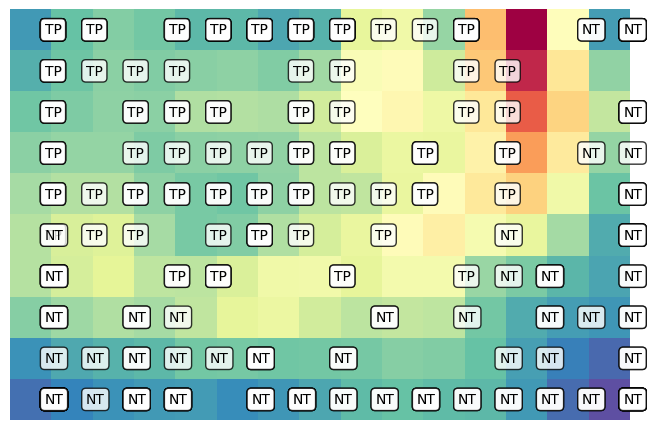

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [54]:
import somoclu
tcga_dataset_ = np.array(tcga_dataset.df)
print(len(tcga_dataset_))
tcga_som = somoclu.Somoclu(15, 10,data=tcga_dataset_, maptype="planar",
                      compactsupport=False)
tcga_som.train(epochs=100)
tcga_som.view_umatrix(labels=tcga_dataset.labels)

222


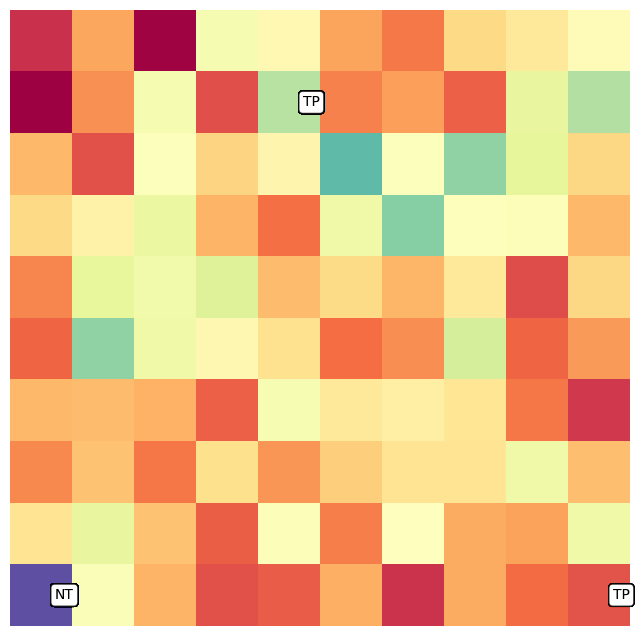

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [55]:
# Visualise the representations generated by the representation layer and see if it has two clusters as expected
tcga_representations_ = np.array(tcga_representations)
print(len(tcga_representations_))
tcga_som_rep = somoclu.Somoclu(10, 10,data=tcga_representations_, maptype="planar",
                      compactsupport=False)
tcga_som_rep.train(epochs=200)
tcga_som_rep.view_umatrix(labels=tcga_dataset.labels)

In [56]:
# Perform K-means clustering
# Assuming you have numpy arrays for data and labels
data = np.array(tcga_dataset.df)
rep_data = np.array(tcga_representations)
labels = tcga_dataset.labels
# Define the mapping
label_mapping = {'TP': 1, 'NT': 0}
# Convert categorical labels to numeric labels
numeric_labels = np.array([label_mapping[label] for label in labels])

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


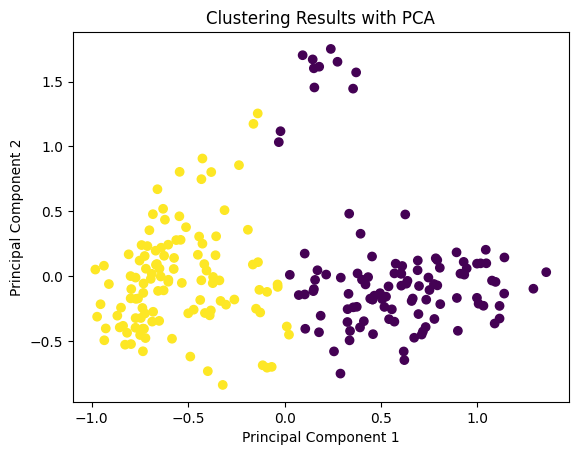

In [57]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming you have your data stored in the 'data' array

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_data = pca.fit_transform(data)

# Perform clustering on the reduced data
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(reduced_data)

# Visualize the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Results with PCA')
plt.show()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


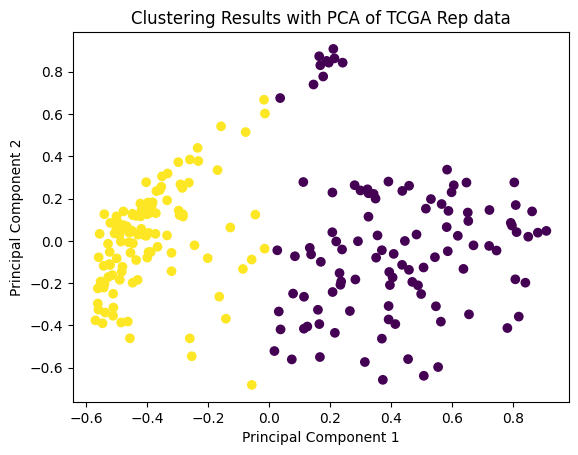

In [58]:
# Assuming you have your data stored in the 'data' array

# Apply PCA for dimensionality reduction
pca_rep = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_rep_data = pca_rep.fit_transform(rep_data)

# Perform clustering on the reduced data
n_clusters_rep = 2
kmeans_rep = KMeans(n_clusters=n_clusters_rep)
cluster_labels_rep = kmeans_rep.fit_predict(reduced_rep_data)

# Visualize the clusters
plt.scatter(reduced_rep_data[:, 0], reduced_rep_data[:, 1], c=cluster_labels_rep, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Results with PCA of TCGA Rep data')
plt.show()

In [69]:
from sklearn.ensemble import RandomForestClassifier
# Train a random forest classifier on the encoded features
rf = RandomForestClassifier()
rf.fit(rep_data, numeric_labels)

# Select a specific prediction for which you want to check feature importances
target_prediction = 1  # Change this to the desired prediction

# Get the indices of samples with the target prediction
target_indices = np.where(rf.predict(rep_data) == target_prediction)[0]

# Get the feature importances for the target samples
target_importances = rf.feature_importances_

# Sort the genes based on their importances
sorted_indices = np.argsort(target_importances)[::-1]

# Define the number of top genes to consider
top_genes_count = 15

# Select the top genes based on their importances
top_genes = sorted_indices[:top_genes_count]
top_importances = target_importances[top_genes]

Gene 52 with importance 0.2971
Gene 24 with importance 0.1612
Gene 62 with importance 0.1342
Gene 36 with importance 0.0629
Gene 14 with importance 0.0511
Gene 12 with importance 0.0428
Gene 25 with importance 0.0405
Gene 2 with importance 0.0321
Gene 27 with importance 0.0311
Gene 30 with importance 0.0264
Gene 47 with importance 0.0236
Gene 51 with importance 0.0178
Gene 49 with importance 0.0154
Gene 6 with importance 0.0150
Gene 57 with importance 0.0125


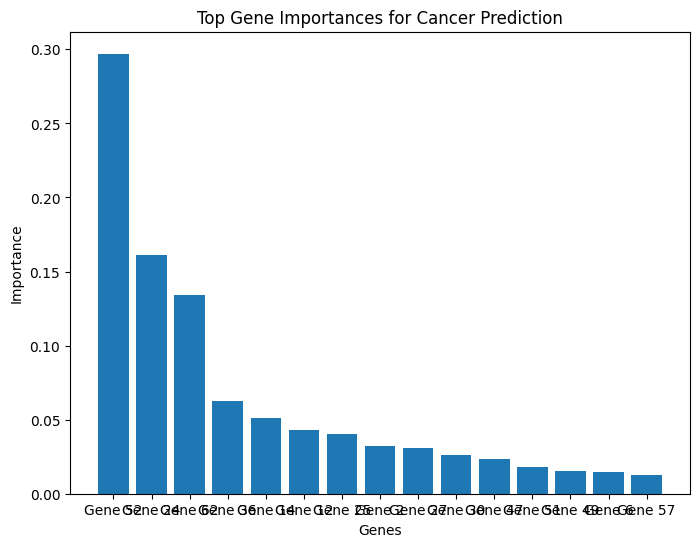

In [70]:
# Print the top genes and their importances
for gene_idx, importance in zip(top_genes, top_importances):
    print(f"Gene {gene_idx} with importance {importance:.4f}")

# Visualize the feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(top_genes_count), top_importances, align='center')
plt.xticks(range(top_genes_count), [f"Gene {gene_idx}" for gene_idx in top_genes])
plt.xlabel('Genes')
plt.ylabel('Importance')
plt.title('Top Gene Importances for Cancer Prediction')
plt.show()

In [71]:
# Map the encoded features to the corresponding hidden layer 1 neurons
mapped_hidden1 = []
for encoded_feature_idx in top_genes:
    # Retrieve the weights of the connections between hidden layer 2 and the encoded layer
    weights_hidden_two_to_encoded = autoencoder.get_weights_hidden_two_to_encoded()

    # Find the indices of the hidden layer 2 neurons with the highest weights for this encoded feature
    max_weight_idx_hidden_two = np.argmax(weights_hidden_two_to_encoded[:, encoded_feature_idx])

    # Add the hidden layer 2 index and its corresponding encoded feature index to the mapped_hidden1 list
    mapped_hidden1.append((max_weight_idx_hidden_two, encoded_feature_idx))

# Map the hidden layer 1 neurons to the corresponding genes
mapped_genes = []
for hidden_two_idx, encoded_feature_idx in mapped_hidden1:
    # Retrieve the weights of the connections between hidden layer 1 and the encoded layer
    weights_hidden_one_to_encoded = autoencoder.get_weights_hidden_one()

    # Find the indices of the hidden layer 1 neurons with the highest weights for this hidden layer 2 neuron
    max_weight_idx_hidden_one = np.argmax(weights_hidden_one_to_encoded[hidden_two_idx])

    # Add the hidden layer 1 index and its corresponding gene index to the mapped_genes list
    mapped_genes.append((max_weight_idx_hidden_one, encoded_feature_idx))




In [72]:
# Create an empty dictionary to store the mapped genes
mapped_genes_dict = {}
# Iterate over the mapped genes and update the dictionary
for hidden_one_idx, encoded_feature_idx in mapped_genes:
    gene_idx = hidden_one_idx  # Assuming the gene index is the same as the hidden layer 1 index

    # Get the label for the gene index
    labels = tcga_dataset.features
    gene_label = labels[gene_idx]

    # Check if the gene is already in the dictionary
    if gene_label in mapped_genes_dict:
        # If the gene is already present, increment the corresponding value
        mapped_genes_dict[gene_label] += 1
    else:
        # If the gene is not present, add it to the dictionary with the initial count of 1
        mapped_genes_dict[gene_label] = 1

# Print the mapped genes and their corresponding encoded features
for gene_label, count in mapped_genes_dict.items():
    print(f"Gene {gene_label} maps to encoded features with count {count}")

Gene UGT1A1 maps to encoded features with count 3
Gene RFNG maps to encoded features with count 2
Gene UGT1A8 maps to encoded features with count 2
Gene NAGPA maps to encoded features with count 1
Gene FUT6 maps to encoded features with count 1
Gene UGT2A2 maps to encoded features with count 1
Gene HS3ST5 maps to encoded features with count 1
Gene FUT9 maps to encoded features with count 1
Gene PMM1 maps to encoded features with count 1
Gene HS3ST4 maps to encoded features with count 1
Gene SLC35D2 maps to encoded features with count 1
